In [1]:
import numpy as np
import pandas as pd
import os
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import datetime
import matplotlib.pyplot as plt

In [2]:
rfm_data = pd.read_csv('/kaggle/input/bigot-benjamin-2-notebook-exploration-012025/customers_features.csv')

display(rfm_data.head())
display(rfm_data.info())

,customer_unique_id,recency,frequency,monetary,avg_review_score,total_items
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,5.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4.0,1.0
2,0000f46a3911fa3c0805444483337064,585,1,86.22,3.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,43.62,4.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,336,1,196.89,5.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  99441 non-null  object 
 1   recency             99441 non-null  int64  
 2   frequency           99441 non-null  int64  
 3   monetary            99441 non-null  float64
 4   avg_review_score    99441 non-null  float64
 5   total_items         99441 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 4.6+ MB


None

In [3]:
db_path = "/kaggle/input/olist-database/olist.db"

conn = sqlite3.connect(db_path)

tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)
display("Tables disponibles dans la base de données :", tables)

customers_data = pd.read_sql_query("SELECT * FROM customers", conn)
orders_data = pd.read_sql_query("SELECT * FROM orders", conn)

'Tables disponibles dans la base de données :'

,name
0,customers
1,geoloc
2,order_items
3,order_pymts
4,order_reviews
5,orders
6,products
7,sellers
8,translation


In [4]:
def create_features_for_date(conn, date_limit):
    """
    Génère les statistiques RFM et la moyenne des scores des avis pour une date limite donnée 
    en filtrant les commandes dans la base SQLite.
    """
    query = f"""
    SELECT
        customers.customer_id,
        MAX(orders.order_purchase_timestamp) AS last_order_date,
        COUNT(orders.order_id) AS frequency,
        SUM(order_pymts.payment_value) AS monetary,
        AVG(order_reviews.review_score) AS avg_review_score
    FROM customers
    JOIN orders ON customers.customer_id = orders.customer_id
    JOIN order_pymts ON orders.order_id = order_pymts.order_id
    LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
    WHERE orders.order_purchase_timestamp <= '{date_limit}'
    GROUP BY customers.customer_id
    """
    rfm = pd.read_sql_query(query, conn)
    
    # Convertir la date de la dernière commande en "Recency" (jours depuis la dernière commande)
    date_limit_dt = pd.to_datetime(date_limit)
    rfm['last_order_date'] = pd.to_datetime(rfm['last_order_date'])
    rfm['recency'] = (date_limit_dt - rfm['last_order_date']).dt.days

    # Garder uniquement les colonnes RFM et la moyenne des scores d'avis
    rfm = rfm[['recency', 'frequency', 'monetary', 'avg_review_score']]
    
    return rfm

In [5]:
query = """
SELECT 
    MIN(order_purchase_timestamp) AS first_order_date,
    MAX(order_purchase_timestamp) AS last_order_date
FROM orders;
"""

dates = pd.read_sql_query(query, conn)
display(dates)

,first_order_date,last_order_date
0,2016-09-04 21:15:19,2018-10-17 17:30:18


In [6]:
# Définir la date de départ T0
start_date = "2017-10-17"

# Générer les statistiques RFM pour T0
rfm_F0 = create_features_for_date(conn, start_date)
rfm_F0['avg_review_score'].fillna(rfm_F0['avg_review_score'].mean(), inplace=True)

# Standardiser les données RFM
scaler_M0 = StandardScaler().fit(rfm_F0[['recency', 'frequency', 'monetary', 'avg_review_score']])
rfm_F0_scaled = scaler_M0.transform(rfm_F0[['recency', 'frequency', 'monetary', 'avg_review_score']])

# Entraîner le modèle KMeans initial (M0)
kmeans_M0 = KMeans(n_clusters=5, random_state=42).fit(rfm_F0_scaled)

<ipython-input-6-0c5fb49b4f7e>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_F0['avg_review_score'].fillna(rfm_F0['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Calcul des clusters pour la date 2017-10-17


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-10-17 | ARI : 1.0000
Calcul des clusters pour la date 2017-10-24


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-10-24 | ARI : 0.9788
Calcul des clusters pour la date 2017-10-31


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-10-31 | ARI : 0.9366
Calcul des clusters pour la date 2017-11-07


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-11-07 | ARI : 0.9028
Calcul des clusters pour la date 2017-11-14


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-11-14 | ARI : 0.8599
Calcul des clusters pour la date 2017-11-21


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-11-21 | ARI : 0.8259
Calcul des clusters pour la date 2017-11-28


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-11-28 | ARI : 0.8331
Calcul des clusters pour la date 2017-12-05


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-12-05 | ARI : 0.8204
Calcul des clusters pour la date 2017-12-12


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-12-12 | ARI : 0.8141
Calcul des clusters pour la date 2017-12-19


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-12-19 | ARI : 0.7972
Calcul des clusters pour la date 2017-12-26


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2017-12-26 | ARI : 0.7526
Calcul des clusters pour la date 2018-01-02


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-01-02 | ARI : 0.7256
Calcul des clusters pour la date 2018-01-09


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-01-09 | ARI : 0.7073
Calcul des clusters pour la date 2018-01-16


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-01-16 | ARI : 0.7148
Calcul des clusters pour la date 2018-01-23


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-01-23 | ARI : 0.6929
Calcul des clusters pour la date 2018-01-30


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-01-30 | ARI : 0.6767
Calcul des clusters pour la date 2018-02-06


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-02-06 | ARI : 0.5914
Calcul des clusters pour la date 2018-02-13


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-02-13 | ARI : 0.6398
Calcul des clusters pour la date 2018-02-20


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-02-20 | ARI : 0.6137
Calcul des clusters pour la date 2018-02-27


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-02-27 | ARI : 0.6067
Calcul des clusters pour la date 2018-03-06


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-03-06 | ARI : 0.5554
Calcul des clusters pour la date 2018-03-13


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-03-13 | ARI : 0.5440
Calcul des clusters pour la date 2018-03-20


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-03-20 | ARI : 0.5291
Calcul des clusters pour la date 2018-03-27


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-03-27 | ARI : 0.5190
Calcul des clusters pour la date 2018-04-03


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-04-03 | ARI : 0.5885
Calcul des clusters pour la date 2018-04-10


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-04-10 | ARI : 0.4565
Calcul des clusters pour la date 2018-04-17


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-04-17 | ARI : 0.6709
Calcul des clusters pour la date 2018-04-24


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-04-24 | ARI : 0.4371
Calcul des clusters pour la date 2018-05-01


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-05-01 | ARI : 0.4374
Calcul des clusters pour la date 2018-05-08


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-05-08 | ARI : 0.4384
Calcul des clusters pour la date 2018-05-15


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-05-15 | ARI : 0.6276
Calcul des clusters pour la date 2018-05-22


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-05-22 | ARI : 0.5913
Calcul des clusters pour la date 2018-05-29


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-05-29 | ARI : 0.5405
Calcul des clusters pour la date 2018-06-05


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-06-05 | ARI : 0.5019
Calcul des clusters pour la date 2018-06-12


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-06-12 | ARI : 0.4862
Calcul des clusters pour la date 2018-06-19


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-06-19 | ARI : 0.5074
Calcul des clusters pour la date 2018-06-26


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-06-26 | ARI : 0.4959
Calcul des clusters pour la date 2018-07-03


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-07-03 | ARI : 0.4905
Calcul des clusters pour la date 2018-07-10


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-07-10 | ARI : 0.4653
Calcul des clusters pour la date 2018-07-17


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-07-17 | ARI : 0.4518
Calcul des clusters pour la date 2018-07-24


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-07-24 | ARI : 0.4572
Calcul des clusters pour la date 2018-07-31


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-07-31 | ARI : 0.4402
Calcul des clusters pour la date 2018-08-07


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-08-07 | ARI : 0.4406
Calcul des clusters pour la date 2018-08-14


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-08-14 | ARI : 0.4388
Calcul des clusters pour la date 2018-08-21


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-08-21 | ARI : 0.4296
Calcul des clusters pour la date 2018-08-28


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-08-28 | ARI : 0.4025
Calcul des clusters pour la date 2018-09-04


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-09-04 | ARI : 0.3665
Calcul des clusters pour la date 2018-09-11


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-09-11 | ARI : 0.3309
Calcul des clusters pour la date 2018-09-18


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-09-18 | ARI : 0.2963
Calcul des clusters pour la date 2018-09-25


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-09-25 | ARI : 0.2675
Calcul des clusters pour la date 2018-10-02


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-10-02 | ARI : 0.2513
Calcul des clusters pour la date 2018-10-09


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-10-09 | ARI : 0.2346
Calcul des clusters pour la date 2018-10-16


<ipython-input-7-3a774757c3da>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Date : 2018-10-16 | ARI : 0.2154


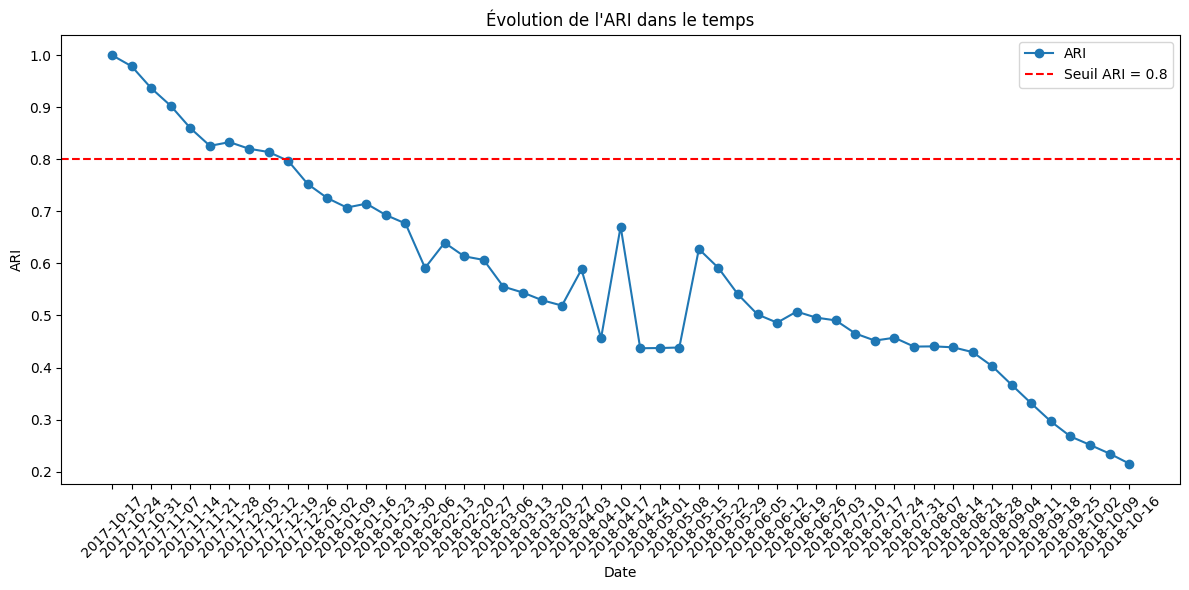

In [7]:
# Définir la plage temporelle pour les simulations
end_date = "2018-10-17"
date_interval = datetime.timedelta(days=7)

current_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end_date_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d")
ari_scores = []

# Itérer sur chaque intervalle de temps (1 semaine)
while current_date <= end_date_dt:
    print(f"Calcul des clusters pour la date {current_date.strftime('%Y-%m-%d')}")

    # Générer les statistiques RFM + avg_review_score pour la date actuelle
    rfm_Fi = create_features_for_date(conn, current_date.strftime("%Y-%m-%d"))

    # Vérification et traitement des valeurs manquantes pour avg_review_score
    if 'avg_review_score' in rfm_Fi.columns:
        rfm_Fi['avg_review_score'].fillna(rfm_Fi['avg_review_score'].mean(), inplace=True)
    else:
        rfm_Fi['avg_review_score'] = rfm_Fi['avg_review_score'].mean()  # Gestion si la colonne manque

    # Standardiser les données avec le scaler initial M0
    rfm_Fi_scaled = scaler_M0.transform(rfm_Fi[['recency', 'frequency', 'monetary', 'avg_review_score']])

    # Prédiction avec le modèle initial M0
    Ci_init = kmeans_M0.predict(rfm_Fi_scaled)

    # Entraîner un nouveau modèle KMeans sur les données actuelles
    kmeans_M1 = KMeans(n_clusters=5, random_state=42).fit(rfm_Fi_scaled)
    Ci_new = kmeans_M1.labels_

    # Calculer l'ARI entre les clusters initiaux (M0) et les clusters nouvellement entraînés (M1)
    ari = adjusted_rand_score(Ci_init, Ci_new)
    ari_scores.append((current_date.strftime("%Y-%m-%d"), ari))
    print(f"Date : {current_date.strftime('%Y-%m-%d')} | ARI : {ari:.4f}")

    # Avancer à la semaine suivante
    current_date += date_interval

# Afficher les résultats de l'ARI
ari_df = pd.DataFrame(ari_scores, columns=["Date", "ARI"])
plt.figure(figsize=(12, 6))
plt.plot(ari_df["Date"], ari_df["ARI"], marker="o", label="ARI")
plt.axhline(y=0.8, color="r", linestyle="--", label="Seuil ARI = 0.8")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("ARI")
plt.title("Évolution de l'ARI dans le temps")
plt.legend()
plt.tight_layout()
plt.show()

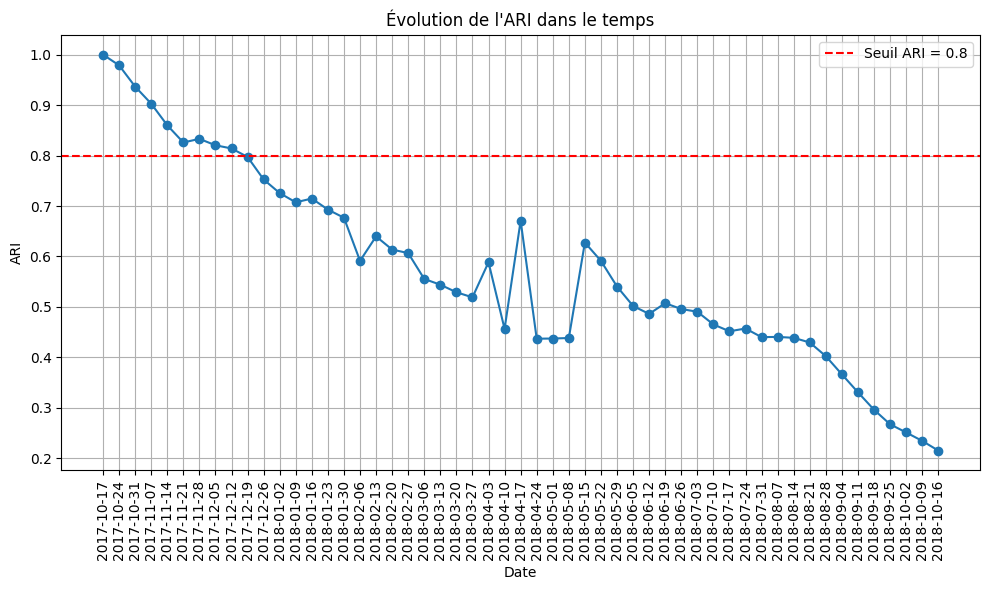

In [8]:
dates, scores = zip(*ari_scores)

# Tracer l'évolution de l'ARI
plt.figure(figsize=(10, 6))
plt.plot(dates, scores, marker='o')
plt.axhline(0.8, color='r', linestyle='--', label="Seuil ARI = 0.8")
plt.title("Évolution de l'ARI dans le temps")
plt.xlabel("Date")
plt.ylabel("ARI")
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()